In [32]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, TextInput, DateRangeSlider, HelpButton, Tooltip, DataTable
from bokeh.models import NumberFormatter, TableColumn, RadioGroup, Button, CustomJS, SetValue
from bokeh.plotting import figure
from bokeh.models.dom import HTML
from bokeh.themes import Theme
from bokeh.palettes import Spectral6

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor

#CONSTANTS
MAX_WIDTH_SLIDERS=600
BACKGROUND_C= "#fefffa"
DATASET_LENGTH=90
MAIN_FIG_HEIGHT=340
MIN_WIDTH=400
MODEL_OPTIONS=["SARIMAX", "RandomForestRegressor", "XGB"]


'''SYNTHETIC DATA GENERATION0.03
INCLUDING: {
seasonal_component: amplitude, frequency, shift
trend_component: slope, quadratic_curvature, CUBIC_CURVATURE
noise: standard normal distributed with mean=0, sd=1
AUTOCORELLATION : 
}
'''


# -----------------------------------------------TIME SERIES GENERATOR FUNDAMENTALS---------------------------------- #

def generate_seasonal_component(t, amplitude, frequency, shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + shift* np.pi)

def generate_trend_component(t, slope, curvature_quadratic, curvature_cubic):
    return slope * t + curvature_quadratic * t**2 + curvature_cubic * t**3

def generate_autoregressive_component(t, ar_coefficients):
    ar_data = np.zeros_like(t)
    for i in range(len(ar_coefficients)):
        if i == 0:
            continue
        ar_data[i] = np.sum(ar_data[:i] * ar_coefficients[:i]) + np.random.randn()    
    return ar_data

def generate_noise(noise_level):
    return np.round(noise_level * np.random.randn(len(t)),4)

def generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic, curvature_cubic,
                                   ar_coefficients=None):
    seasonal_component = generate_seasonal_component(t, amplitude, frequency, shift)
    trend_component = generate_trend_component(t, slope, curvature_quadratic, curvature_cubic)
    
    if ar_coefficients is not None:
        ar_data = generate_autoregressive_component(t, ar_coefficients)
    else:
        ar_data = np.zeros_like(t)

    synthetic_data_ = seasonal_component + trend_component + ar_data
    return np.round(synthetic_data_, 4)

# SET INITIAL PARAMETERS   
t = np.linspace(0, 30, 90)
amplitude = 2.0
shift = 0
frequency = 0.1
slope = 0.1
curvature_quadratic = 0.0
curvature_cubic = 0
noise_level = 0.5
ar_coefficients = np.array([0.0, -0.0, 0.0])

# CREATE INITIAL TIME SERIES
synthetic_data = generate_synthetic_time_series(t, amplitude, frequency, slope, shift, curvature_quadratic,
                                                 curvature_cubic, ar_coefficients=None)
default_noise = generate_noise(noise_level)

synthetic_data = pd.Series(synthetic_data + default_noise)
synthetic_data.round(decimals=4)



#-----------------------------------------------BASIC BOKEH IMPLEMENTATION-------------------------------------------#

plot = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series",
              tools="pan,reset,save,wheel_zoom", margin=(0, 40, 10, 40), background_fill_color=BACKGROUND_C,
              x_range=[0, 90], y_range=[-7, 25], align="center")


source = ColumnDataSource(data=dict(time=synthetic_data.index, synthetic_data=synthetic_data.values))
plot.line('time', 'synthetic_data', source=source, line_width=3, line_alpha=0.8,  legend_label="synthetic_data")
plot.legend.location = "top_left"
plot.legend.background_fill_alpha = 0.8
plot.xaxis.axis_label = "time"
plot.yaxis.axis_label = "value"


text = TextInput(title="title", value='Synthetic Time Series fancy')
offset = Slider(title="shift", value=0.0, start=-5.0, end=5.1, step=0.1, min_width=200, align="center",
                                max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width")
slope = Slider(title="slope", value=0.2, start=-1.0, end=1.3, step=0.1, align="center")
amplitude = Slider(title="amplitude", value=2.0, start=-6.0, end=6.0, step=0.5, align="center")
phase = Slider(title="phase", value=0.0, start=0.0, end=2, step=0.5, align="center")
freq = Slider(title="frequency", value=0.1, start=0.02, end=0.3, step=0.02, align="center")
noise = Slider(title="noise", value=0.5, start=0.0, end=2, step=0.1, align="center")
date_range_slider = DateRangeSlider(value=(date(2018, 9, 15), date(2020, 9, 15)), step=10, start=date(2016, 9, 1),
                                    end=date(2022, 4, 15), margin=(0, 30, 0, 30), min_width=200,
                                    max_width=MAX_WIDTH_SLIDERS, width_policy="max",sizing_mode="stretch_width", align="center")
train_test_split_slider = Slider(title="train_test_split", value=60, start=45, end=80, step=1, align="center")

#Components such as row() and column() elements share their sizing mode with all of their children that do not have their own explicit sizing mode.



# -----------------------------------------------CALLBACK IMPLEMENTATION--------------------------------------------#
def update_title(attrname, old, new):
    plot.title.text = text.value

def update_data(attrname, old, new):

    # Get the current slider values
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ default_noise)
    synthetic_data_temp.round(decimals=4)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)

def update_noise(attrname, old, new):
    global default_noise

    n = noise.value
    updated_noise = generate_noise(n)
    default_noise=updated_noise
    
    a = amplitude.value
    b = offset.value
    p = phase.value
    k = freq.value
    s = slope.value

    synthetic_data_temp = pd.Series(generate_synthetic_time_series(t, a, k, s, p, curvature_quadratic, curvature_cubic,
                                    ar_coefficients)+ updated_noise)
    source.data = dict(time=synthetic_data_temp.index, synthetic_data=synthetic_data_temp.values)
    

text.on_change('value', update_title)
noise.on_change("value", update_noise)

#for widget_ in [offset,slope, amplitude, phase, freq]:
 #   widget_.on_change('value', update_data)



# -------------------------------------MODEL IMPLEMENTATION & BOKEH TRANSFORMATION------------------------------------#
# Data Preparation & Train-Test Split

y_train_CDS = ColumnDataSource({"time":[], "value": []})
y_test_CDS = ColumnDataSource({"time":[],"value":[]})
y_pred_CDS = ColumnDataSource({"time": [],"lower_y": [], "upper_y": [],"predictions":[]})

plot_2 = figure(min_width=MIN_WIDTH, max_width=1800, height=MAIN_FIG_HEIGHT, width_policy="max", title="Synthetic time series prediction",
              tools="pan,reset,save,wheel_zoom", margin=(0, 40, 10, 40), background_fill_color=BACKGROUND_C,
                x_range=plot.x_range, y_range=[-7, 25], align="center")
plot_2.line('time', 'value', source=y_train_CDS, line_width=3, line_alpha=0.8, legend_label="Train_data")
plot_2.line('time', 'value', source=y_test_CDS, line_width=3, line_alpha=0.8, line_color="#2ca02c", legend_label="Test_data")
plot_2.line('time', 'predictions', source=y_pred_CDS, line_width=3, line_alpha=0.8, line_color="#ff7f0e", legend_label="model_prediction")
plot_2.legend.location = "top_left"
plot_2.legend.background_fill_alpha = 0.8
plot_2.xaxis.axis_label = "time"
plot_2.yaxis.axis_label = "value"




def create_model(train_df, test_df, model_selection):
    assert model_selection in MODEL_OPTIONS, f"'{model_selection}' is not a valid choise. Please choose from {MODEL_OPTIONS}."

    if model_selection == "SARIMAX":
        ARMAmodel_ = ARIMA(train_df["values"], order = (2, 2, 2))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data
        SARIMAXmodel_ = SARIMAX(train_df["values"], order = (1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
        current_model = SARIMAXmodel_.fit()
        print(current_model.summary().tables[1])
        y_pred = current_model.get_forecast(len(test_df.index))
        y_pred_df = y_pred.conf_int(alpha = 0.05) 
        y_pred_df["Predictions"] = current_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test_df["time"]
        y_pred_out = y_pred_df["Predictions"] 
        #current_model.plot_diagnostics(figsize=(16, 8))

    elif current_model =="RF_regressor":
        rf_regressor = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=5)
        current_model = rf_regressor.fit()
        ##TODO very much

    return current_model, y_pred_df


def update_model_(split_ind=60, model_selection="SARIMAX"):
    print('button clicked.')
    if train_test_split_slider.value is not None:
        split_ind=train_test_split_slider.value
    train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
    test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})
    
    
    ####---> GO INTO MODEL FUNC, RETURN:(train_df, test_df, pred_df)
    current_model, pred_df = create_model(train_df=train_df, test_df=test_df, model_selection=model_selection)


    y_train_CDS.data = ({"time": train_df["time"],
                        "value": train_df["values"]})
    y_test_CDS.data = ({"time": test_df["time"],
                        "value": test_df["values"]})
    y_pred_CDS.data = ({"time": pred_df.index,
                        "lower_y": pred_df.loc[:,"lower values"].values,
                        "upper_y": pred_df.loc[:,"upper values"].values,
                        "predictions": pred_df.loc[:,"Predictions"].values})
    


               
# def model_creator(d_source, split_ind=60):  #model_creator(datasource, split, model_str, plot_pal?)
#     train_df = pd.DataFrame(data={"time": d_source.data["time"][0:split_ind], "values": d_source.data["synthetic_data"][0:split_ind]})   
#     test_df = pd.DataFrame(data={"time": d_source.data["time"][split_ind-1:], "values": d_source.data["synthetic_data"][split_ind-1:]}) 
#     print(len(test_df))  


#     #####test_ds = synthetic_data[synthetic_data.index >= 60]
#     # Deterministic Model implementation & FIT

#     currentmodel = "current_model"
#     ARMAmodel_ = ARIMA(train_df["values"], order = (2, 2, 2))    #ARIMA(p, d, q) -> pdq account for seasonality, trend, and noise in data
#     SARIMAXmodel_ = SARIMAX(train_df["values"], order = (1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)

#     current_model = SARIMAXmodel_.fit()
#     print(current_model.summary().tables[1])
#     y_pred = current_model.get_forecast(len(test_df.index))
#     y_pred_df = y_pred.conf_int(alpha = 0.05) 
#     y_pred_df["Predictions"] = current_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
#     y_pred_df.index = test_df["time"]
#     y_pred_out = y_pred_df["Predictions"] 
#     current_model.plot_diagnostics(figsize=(16, 8))
#     #plt.plot(y_pred_out, color='Blue', label = 'SARIMAX Predictions')
#     #plt.legend()
#     #plt.show()




# -----------------------------------------------USER EXPLANATION (HTML)----------------------------------------------#
help_slope = HelpButton(tooltip=Tooltip(content=HTML("""
the slope represents the general trend of the time series.<br /> It determines the <b>average increase</b>
in y over a period of time.<br/>More information: <a href="https://en.wikipedia.org/wiki/Slope">slope</a>!
"""), position="right"), align="center")



# -----------------------------------------------DATA TABLE IMPLEMENTATION--------------------------------------------#
columns = [
        TableColumn(field="time", title="time"),
        TableColumn(field="synthetic_data", title="value", formatter=NumberFormatter(format="0.0000")),
    ]

data_table = DataTable(source=source, columns=columns, width=400, height=250, editable=True, align="center")

#comit



# -----------------------------------------------CURRENT_DOC REFRESHMENT--------------------------------------------#
button = Button(label="Apply Model", button_type="success", align="center")
button2 = Button(label="Reset button1", button_type="success", align="center")
button2.js_on_event("button_click", SetValue(button, "label", "Apply Model"))

button.on_click(update_model_)
button.js_on_event("button_click", CustomJS(code="console.log('button: click!', this.toString())"))
button.js_on_event("button_click", SetValue(button, "label", "Model applied"))
      
     
for widget_ in [offset,slope, amplitude, phase, freq]:
    widget_.on_change('value', update_data)  
    #widget_.js_on_change("value", SetValue(button, "label", "Apply Model"))  

                   

radio_group = RadioGroup(labels=["SARIMAX", "RF_regressor", "XGB_Boost"], active=None, align="center")

def radio_handler(new):
    print('Radio button option ' + str(new) + ' selected.')
    #cd.clear()
    #cd.add_root(column(plot, radio_group))

#radio_group.on_event('button_click', radio_handler)
radio_group.js_on_event('button_click', CustomJS(code="""
    console.log('radio_group: active=' + this.origin.active, this.toString())
"""))
radio_group.js_on_event("button_click", SetValue(button, "label", "Apply XY"))

button2.js_on_event("button_click", SetValue(button, "label", radio_group.active))


# -----------------------------------------------FINALIZE LAYOUT CURRENT_DOC--------------------------------------------#


# bokeh serve --show Synth_data_app.py
# bokeh serve Synth_data_app.py --dev                        <---DEV-mode
# http://localhost:5006/Synth_data_app

curdoc().title = "Synthetic data"
slope_with_annot= row(slope, help_slope, align="center")
amplitude_with_annot = row(amplitude, help_slope, align="center")
phase_with_annot = row(phase, help_slope, align="center")
freq_with_annot = row(freq, help_slope, align="center")
noise_with_annot = row(noise, help_slope, align="center")

slider_menu_layout = column(slope_with_annot, amplitude, phase, freq, noise, sizing_mode="stretch_width")
slider_menu_layout_annot = column(slope_with_annot, amplitude_with_annot, phase_with_annot, freq_with_annot,
                                   noise_with_annot, sizing_mode="stretch_width")
model_selection_interface = column(radio_group, train_test_split_slider, button, button2, sizing_mode="stretch_width", align="center")
core_row_layout = row(slider_menu_layout, data_table, model_selection_interface, align="center")

cd = curdoc()
cd.add_root(column(plot, core_row_layout, plot_2, sizing_mode="stretch_width"))
cd.theme = Theme(filename="theme.yaml") #improving the modularity of the app and decouple the style layer from the view layer








##TODO
### Data Generation
#   |--- ADD length of data ? (Current instances: 90)
#   |--- CHANGE to datetime objects ?
#   |--- Apply Feature: Ground_level/Offset
#   |--- Apply Feature: Quadratic/Cubic Slope + Corresponding Widget

### Data Visualization
#    |--- Customizable Autocorrelation Plot (User should choose the lags) (one or span of multiple)
#    |--- distribution of data change

### Forecast Model implementation 
#   |--- 1. State of the Art Deterministic Forecast: (SARMIAX)
#   |--- 2. ML-based: Random Forest
#   |--- 3. ML-based: XGB Boost
#   |--- 4. Sophisticated ML-model: (CNN), (LSTM)

#comment 1

In [33]:
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



def time_series_lagger(data, n_in=1, n_out=1, dropnan=True):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		pandas df: dimensionality LEN_DATA x (N_IN + N_OUT) initial:(90x(5+1))
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	
	# input sequence (t-n, ... t-1, t0)
	for i in range(n_in-1, -1, -1):
		cols.append(df.shift(i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(1, n_out+1):
		cols.append(df.shift(-i))
		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
		
	return agg

def train_test_split(data, test_set_len):
	return data[:-test_set_len, :], data[-test_set_len:, :]



def random_forest_initial(train):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	current_model = RandomForestRegressor(n_estimators=300)
	current_model.fit(trainX, trainy)
	return current_model


def walk_forward_validation_historic(data, test_set_len):
	prediction_list = list()
	train_data, test_data = train_test_split(data.values, test_set_len) #receives np.array (df.values) 90x5 -> returns df 60x5, 30x5
	print(data.shape)
	print(train_data.shape)
	print(test_data.shape)
	current_model = random_forest_initial(train_data)
	for i in range(len(test_data)):
		testX, testy = test_data[i, :-1], test_data[i, -1]      #--> 1x5; 1x1 from 30x5, 30x1
		y_pred= current_model.predict([testX])
		prediction_list.append(y_pred[0])	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred[0]))

	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list



#-----#
#-----#
#-------------------------------------------------------------------------FOLLOWING FUNCTIONS IN DEVELOPMENT-------------------------#
#-----#
#-----#
def random_forest_forecast(train, testX):
	# transform list into array if necessary
	train_ = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train_[:, :-1], train_[:, -1]
	print("trainX: \n{}".format(trainX[0:5]))
	print("trainy:\n{}".format(trainy))
	print(80*"-")
	
	model = RandomForestRegressor(n_estimators=300)
	model.fit(trainX, trainy)
	# make a one-step prediction
	#print("real value: {}".format(train))
	y_pred = model.predict([testX])
	return y_pred[0]


def walk_forward_validation_online(data, test_set_len):
	"""
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		test_set_len: Number of test set observations
	Returns:
		error: 
		test_label: returns the test labels (real values) for the test sequence via 
		prediction_array: returns all prediction via python list
	"""
	prediction_list = list()
	train_data, test_data = train_test_split(data, test_set_len)
	history = [x for x in train_data]     #--> initial: 60x6 
	for i in range(len(test_data)):		  #--> initial: 30x6	
		testX, testy = test_data[i, :-1], test_data[i, -1]     #--> 1x5; 1x1 from 30x5, 30x1
		y_pred = random_forest_forecast(history, testX)		   #--> fit rf on history, evaluate on test instance		
		prediction_list.append(y_pred)						   #--> build y_pred array	
		history.append(test_data[i])						   #--> append to history	
		print('>expected=%.1f, predicted=%.1f' % (testy, y_pred))
		# estimate prediction error
	print(test_data[:, -1])
	error = mean_absolute_error(test_data[:, -1], prediction_list)
	return error, test_data[:, -1], prediction_list
#-------------------------------------------------------------------------FUNCTIONS ABOVE IN DEVELOPMENT-------------------------#

In [34]:
split_ind=60
train_df = pd.DataFrame(data={"time": source.data["time"][0:split_ind], "values": source.data["synthetic_data"][0:split_ind]})   
test_df = pd.DataFrame(data={"time": source.data["time"][split_ind-1:], "values": source.data["synthetic_data"][split_ind-1:]})


In [35]:
data_concatenated = pd.concat([train_df, test_df.iloc[1:,:]], ignore_index=True)
data_concatenated

,time,values
0,0,-0.0674
1,1,0.6010
2,2,1.1685
3,3,0.5276
4,4,1.7512
...,...,...
85,85,1.1911
86,86,2.1895
87,87,2.1838
88,88,1.8164


In [36]:
data_concatenated
tsl = time_series_lagger(data_concatenated.loc[:,"values"].to_list(), n_in=5, n_out=1)
tsl

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
4,-0.0674,0.6010,1.1685,0.5276,1.7512,2.0439
5,0.6010,1.1685,0.5276,1.7512,2.0439,2.1205
6,1.1685,0.5276,1.7512,2.0439,2.1205,2.7279
7,0.5276,1.7512,2.0439,2.1205,2.7279,2.4891
8,1.7512,2.0439,2.1205,2.7279,2.4891,2.1547
...,...,...,...,...,...,...
84,1.2746,0.9264,1.5647,1.4538,1.0004,1.1911
85,0.9264,1.5647,1.4538,1.0004,1.1911,2.1895
86,1.5647,1.4538,1.0004,1.1911,2.1895,2.1838
87,1.4538,1.0004,1.1911,2.1895,2.1838,1.8164


In [37]:
split_index = int(85 * 0.8)
data_train = tsl.iloc[:split_index]
data_test = tsl.iloc[split_index:]

In [38]:
data_train.describe()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1)
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,1.207247,1.268391,1.320215,1.354153,1.408188,1.428821
std,1.583148,1.613189,1.647665,1.668134,1.700165,1.712855
min,-1.996700,-1.996700,-1.996700,-1.996700,-1.996700,-1.996700
25%,0.005850,0.029750,0.029750,0.029750,0.029750,0.029750
50%,1.237950,1.433700,1.618250,1.713850,1.838100,1.984450
75%,2.304425,2.321025,2.391450,2.508550,2.587650,2.669400
max,4.514700,4.514700,4.514700,4.514700,4.514700,4.514700


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Features und Target definieren
X_trainRFR = data_train[['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']]
y_trainRFR = data_train['var1(t+1)']

x_testRFR = data_test[['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']]
y_testRFR = data_test['var1(t+1)']

In [41]:
train_df.head()

,time,values
0,0,-0.0674
1,1,0.6010
2,2,1.1685
3,3,0.5276
4,4,1.7512


In [42]:
train_df_v = train_df.drop(columns=['time'])
train_df_v.head()

,values
0,-0.0674
1,0.6010
2,1.1685
3,0.5276
4,1.7512


Visualisierungen Trainingsset

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

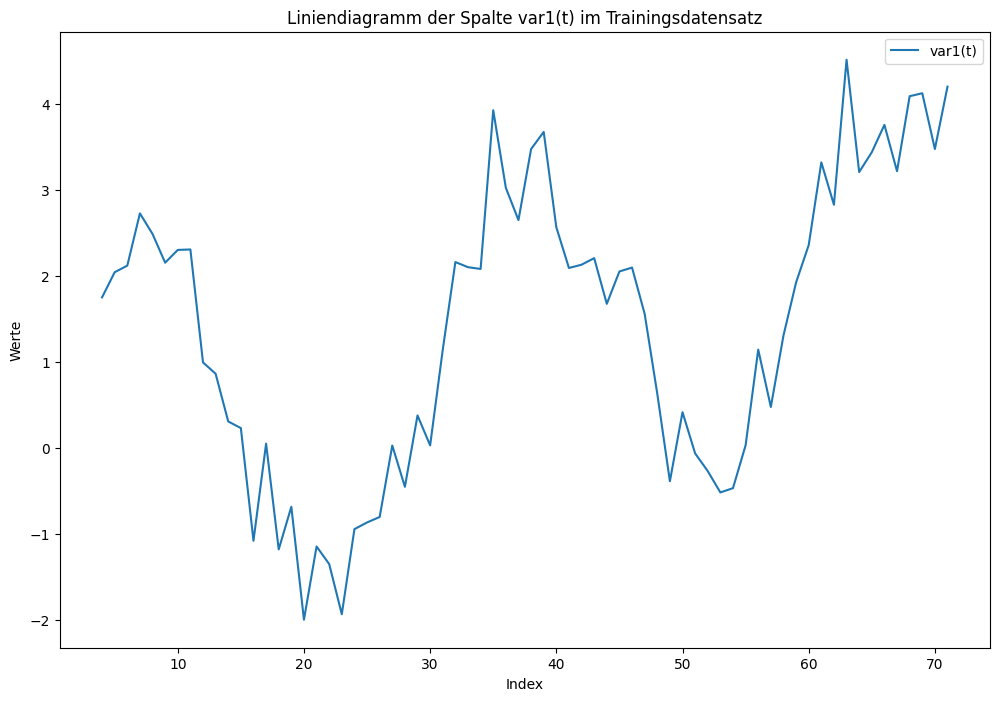

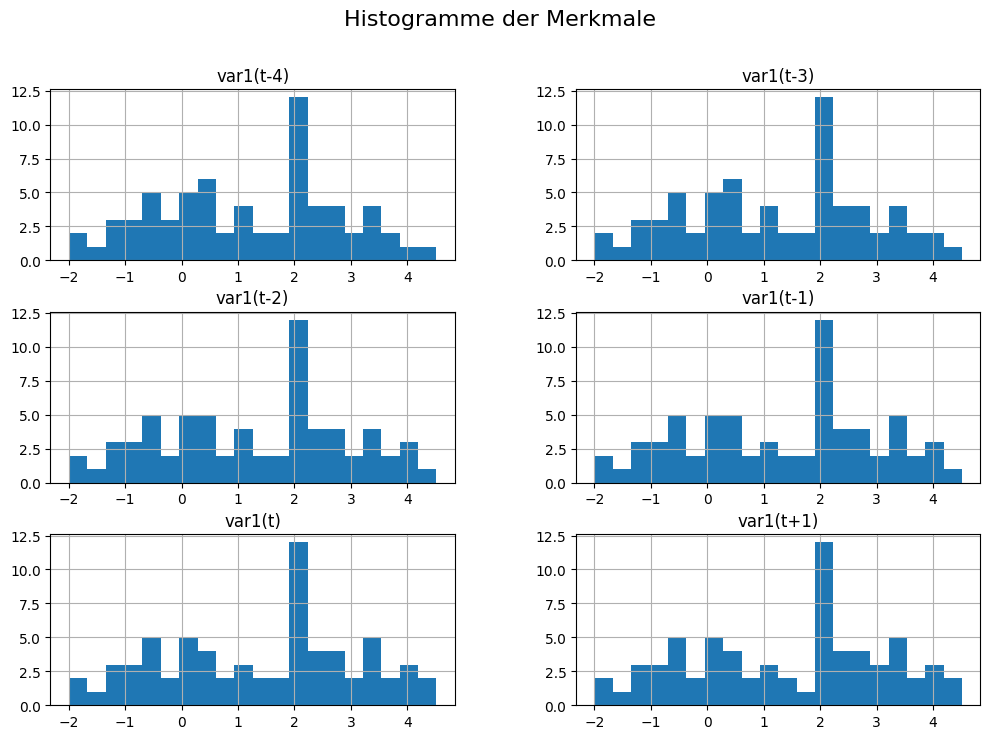

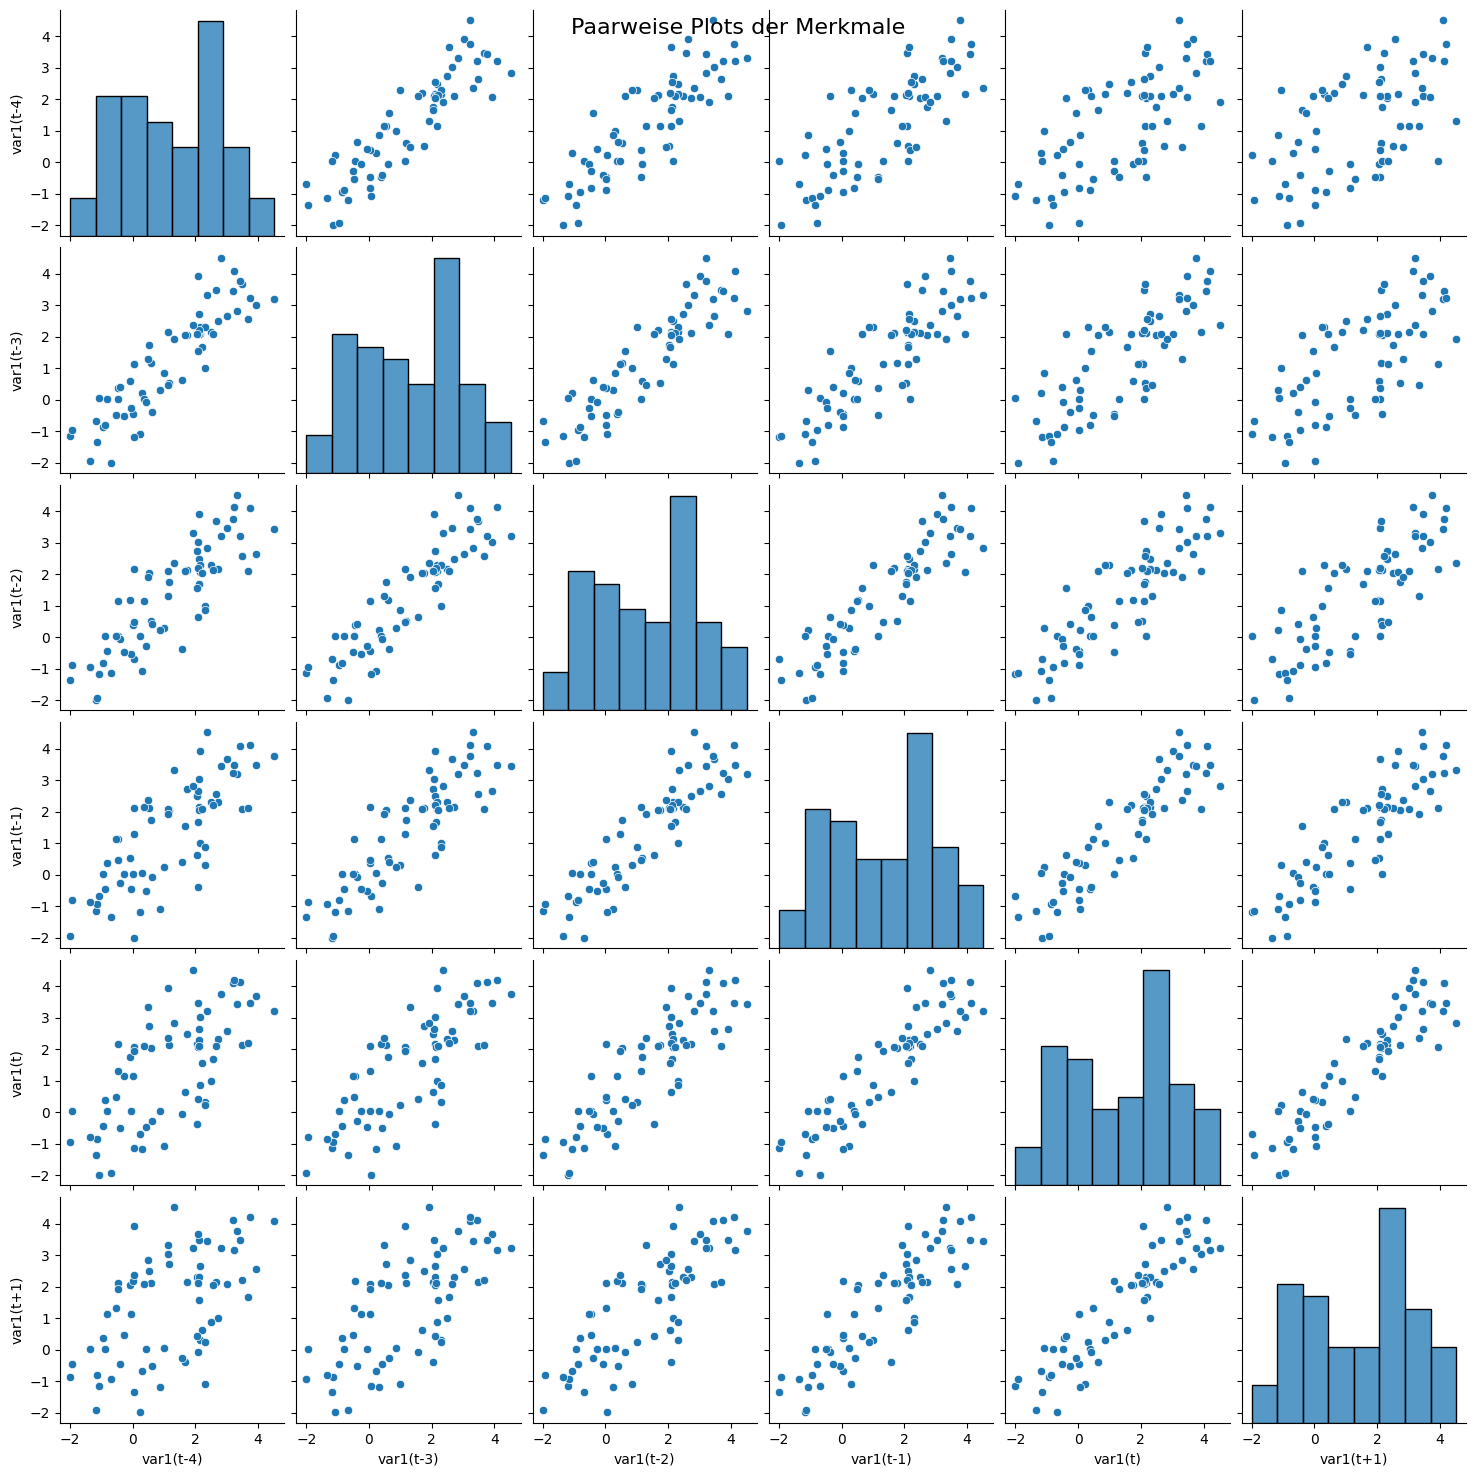

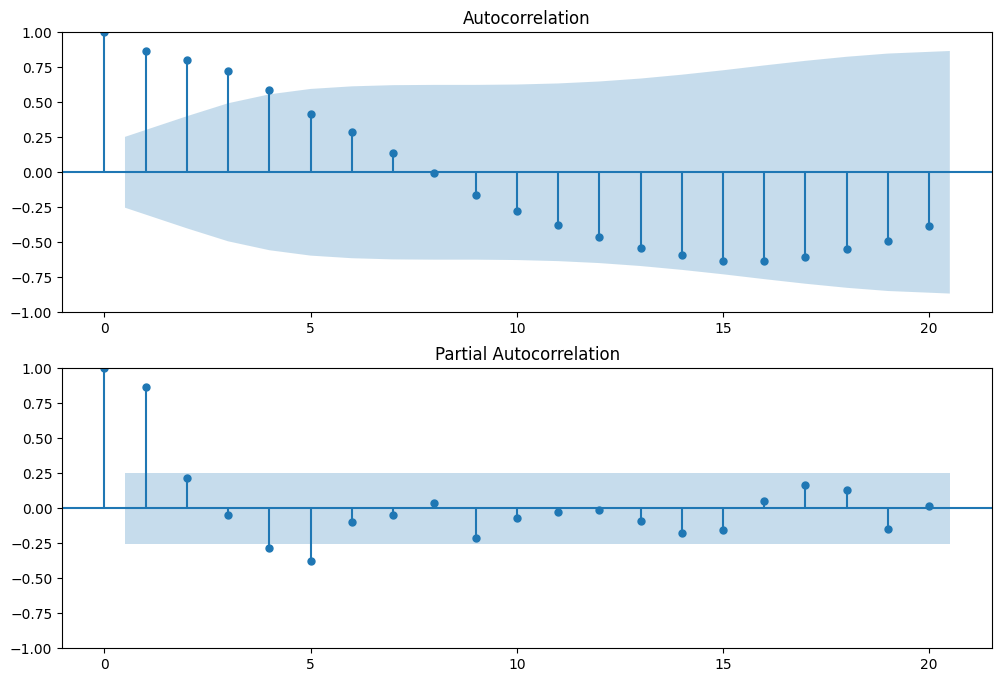


    Erklärung der ACF und PACF Plots:

    1. **Autokorrelationsfunktion (ACF)**:
    - Der ACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags.
    - Die höchste Autokorrelation beträgt 1.00.
    - Signifikante Autokorrelationen wurden bei den folgenden Lags gefunden: [ 0  1  2  3  4  5  6 10 11 12 13 14 15 16 17 18 19 20].

    2. **Partielle Autokorrelationsfunktion (PACF)**:
    - Der PACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags, wobei der Einfluss der zwischenliegenden Lags entfernt wird.
    - Die höchste partielle Autokorrelation beträgt 2.68.
    - Signifikante partielle Autokorrelationen wurden bei den folgenden Lags gefunden: [ 0  1  2  4  5  6  9 14 15 16 17 18 19 20].

    Diese Plots sind besonders nützlich bei der Identifizierung der Ordnung von ARIMA-Modellen (AutoRegressive Integrated Moving Average).
    


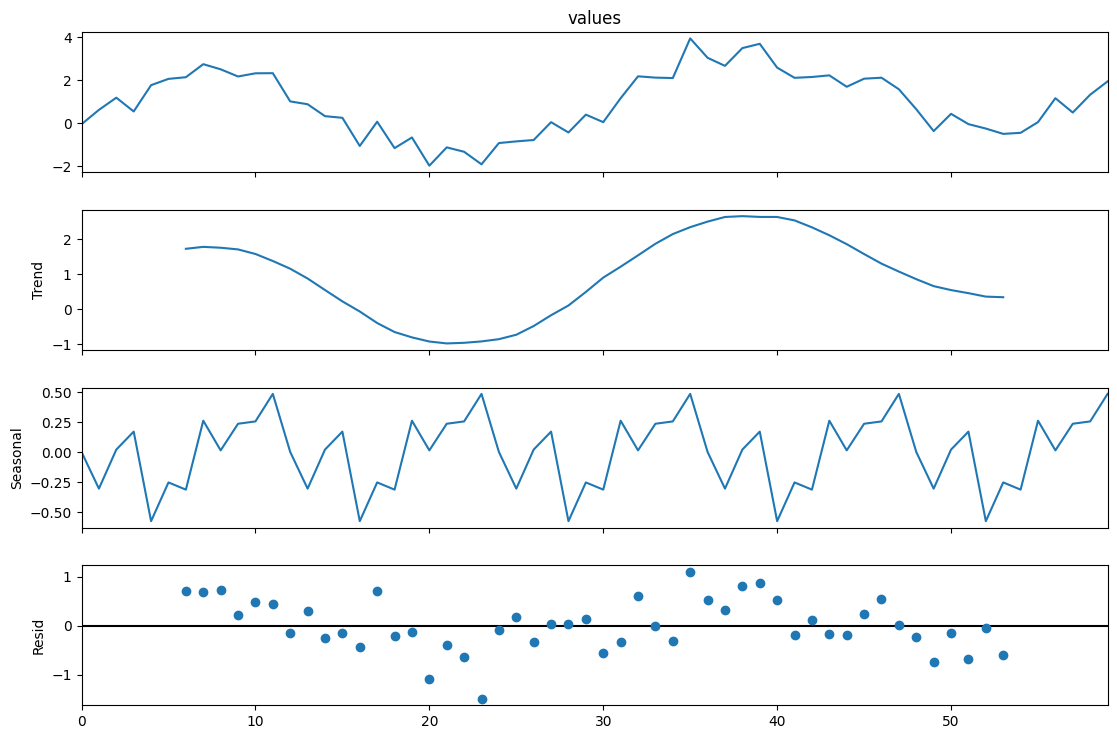


    Die Zeitreihe wurde in ihre Bestandteile zerlegt: Trend, Saisonalität und Residuen.

    1. **Trend**: Dieser zeigt die langfristige Bewegung in der Zeitreihe.
    - Der Mittelwert des Trends beträgt 0.92.
    - Der Trend reicht von einem Minimum von -0.98 bis zu einem Maximum von 2.65.

    2. **Saisonalität**: Dieser Teil zeigt wiederkehrende Muster in der Zeitreihe, die sich regelmäßig wiederholen.
    - Der Mittelwert der Saisonalität beträgt 0.00.
    - Die Saisonalität reicht von einem Minimum von -0.58 bis zu einem Maximum von 0.49.
    - Die Periode der Saisonalität wurde auf 12 gesetzt, was auf monatliche Daten hindeutet.

    3. **Residuen**: Diese repräsentieren die Zufallskomponente der Zeitreihe, die nicht durch Trend oder Saisonalität erklärt wird.
    - Der Mittelwert der Residuen beträgt 0.02.
    - Die Residuen reichen von einem Minimum von -1.49 bis zu einem Maximum von 1.10.

    Die Zerlegung der Zeitreihe hilft uns, die zugrunde liegenden Muster besser zu vers

In [44]:
#Lininen Diagramm
def plot_line_chart(train_df):
    column_name = "var1(t)"
    plt.figure(figsize=(12, 8))
    plt.plot(train_df[column_name], label=column_name)
    plt.title(f'Liniendiagramm der Spalte {column_name} im Trainingsdatensatz')
    plt.xlabel('Index')
    plt.ylabel('Werte')
    plt.legend()
    plt.show()

# Histogramm
def plot_histograms(data_train):
    data_train.hist(figsize=(12, 8), bins=20)
    plt.suptitle('Histogramme der Merkmale', fontsize=16)
    plt.show()

# Paarweise Plots
def plot_pairplots(data_train):
    sns.pairplot(data_train)
    plt.suptitle('Paarweise Plots der Merkmale', fontsize=16)
    plt.show()

# Autocorrelation und Partical Autocorrelation
def plot_acf_and_pacf(train_df):
    values = train_df['values']
    
    # ACF und PACF Werte berechnen
    acf_values = sm.tsa.acf(values, nlags=20)
    pacf_values = sm.tsa.pacf(values, nlags=20)
    
    # ACF und PACF plotten
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(values, lags=20, ax=ax[0])
    sm.graphics.tsa.plot_pacf(values, lags=20, ax=ax[1])
    plt.show()
    
    # Berechnung der dynamischen Erklärungsbestandteile
    significant_acf_lags = np.where(np.abs(acf_values) > 0.2)[0]  # Beispielhaftes Kriterium für Signifikanz
    significant_pacf_lags = np.where(np.abs(pacf_values) > 0.2)[0]
    
    max_acf = np.max(acf_values)
    max_pacf = np.max(pacf_values)
    
    explanation = f"""
    Erklärung der ACF und PACF Plots:

    1. **Autokorrelationsfunktion (ACF)**:
    - Der ACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags.
    - Die höchste Autokorrelation beträgt {max_acf:.2f}.
    - Signifikante Autokorrelationen wurden bei den folgenden Lags gefunden: {significant_acf_lags}.

    2. **Partielle Autokorrelationsfunktion (PACF)**:
    - Der PACF-Plot zeigt die Korrelation der Zeitreihe mit ihren eigenen Werten bei verschiedenen Lags, wobei der Einfluss der zwischenliegenden Lags entfernt wird.
    - Die höchste partielle Autokorrelation beträgt {max_pacf:.2f}.
    - Signifikante partielle Autokorrelationen wurden bei den folgenden Lags gefunden: {significant_pacf_lags}.

    Diese Plots sind besonders nützlich bei der Identifizierung der Ordnung von ARIMA-Modellen (AutoRegressive Integrated Moving Average).
    """
    print(explanation)

# Trend und Saisonalität
def plot_trend_and_season(train_df):
    values = train_df['values']
    decomposition = sm.tsa.seasonal_decompose(values, model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.show()
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()

    explanation = f"""
    Die Zeitreihe wurde in ihre Bestandteile zerlegt: Trend, Saisonalität und Residuen.

    1. **Trend**: Dieser zeigt die langfristige Bewegung in der Zeitreihe.
    - Der Mittelwert des Trends beträgt {trend.mean():.2f}.
    - Der Trend reicht von einem Minimum von {trend.min():.2f} bis zu einem Maximum von {trend.max():.2f}.

    2. **Saisonalität**: Dieser Teil zeigt wiederkehrende Muster in der Zeitreihe, die sich regelmäßig wiederholen.
    - Der Mittelwert der Saisonalität beträgt {seasonal.mean():.2f}.
    - Die Saisonalität reicht von einem Minimum von {seasonal.min():.2f} bis zu einem Maximum von {seasonal.max():.2f}.
    - Die Periode der Saisonalität wurde auf 12 gesetzt, was auf monatliche Daten hindeutet.

    3. **Residuen**: Diese repräsentieren die Zufallskomponente der Zeitreihe, die nicht durch Trend oder Saisonalität erklärt wird.
    - Der Mittelwert der Residuen beträgt {resid.mean():.2f}.
    - Die Residuen reichen von einem Minimum von {resid.min():.2f} bis zu einem Maximum von {resid.max():.2f}.

    Die Zerlegung der Zeitreihe hilft uns, die zugrunde liegenden Muster besser zu verstehen und ermöglicht es uns, Vorhersagemodelle genauer zu erstellen.
    """
    print(explanation)


# Aufrufen der Plot-Funktionen
plot_line_chart(data_train)
plot_histograms(data_train)
plot_pairplots(data_train)
plot_acf_and_pacf(train_df)
plot_trend_and_season(train_df)




Mean Squared Error: 0.5764347741089995


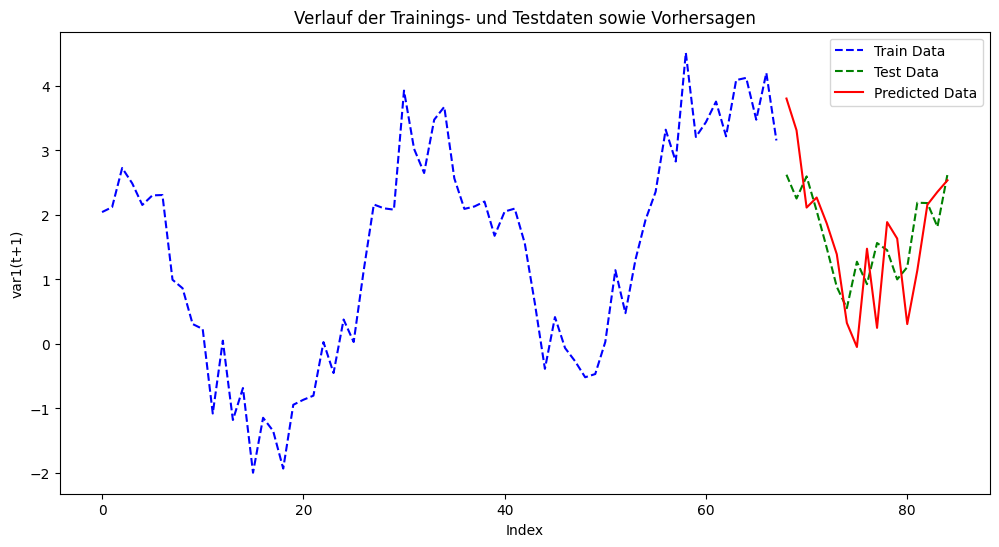

In [45]:
# Random Forest Regressor erstellen und trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_trainRFR, y_trainRFR)

# Vorhersagen auf den Testdaten
y_pred = model.predict(x_testRFR)

# Modellleistung evaluieren
mse = mean_squared_error(y_testRFR, y_pred)
print(f'Mean Squared Error: {mse}')

# Modell und Leistung ausgeben
model, mse

# Visualisierung der Daten
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.plot(np.arange(len(y_trainRFR)), y_trainRFR, label='Train Data', color='blue', linestyle='--')

# Testdaten plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_testRFR, label='Test Data', color='green', linestyle='--')

# Vorhergesagte Werte plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_pred, label='Predicted Data', color='red')

plt.xlabel('Index')
plt.ylabel('var1(t+1)')
plt.title('Verlauf der Trainings- und Testdaten sowie Vorhersagen')
plt.legend()
plt.show()

In [46]:
import shap

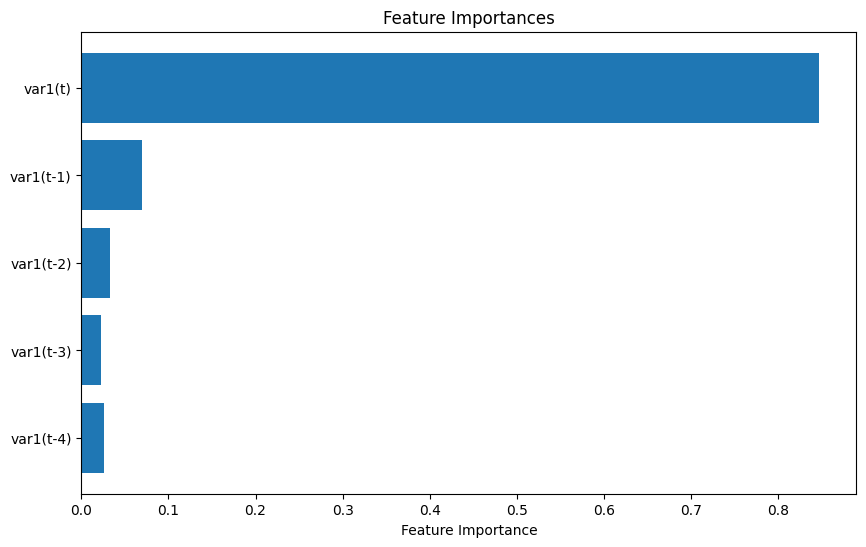

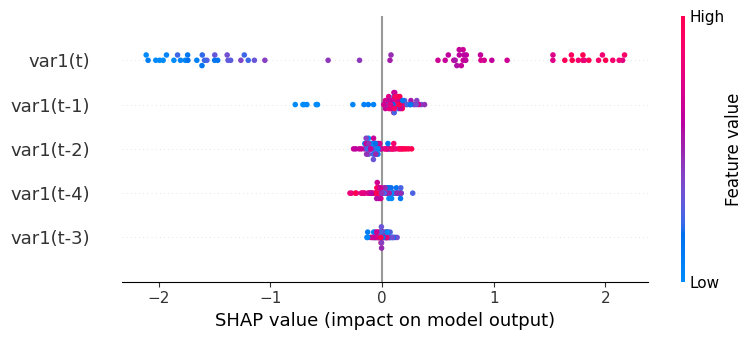

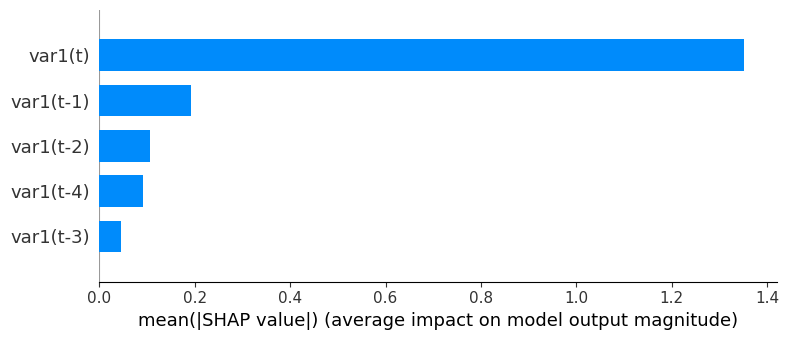

In [47]:
# Feature Importance berechnen und plotten
importances = model.feature_importances_
feature_names = ['var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

# SHAP Werte berechnen und plotten
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trainRFR)

shap.summary_plot(shap_values, X_trainRFR, feature_names=feature_names)
shap.summary_plot(shap_values, X_trainRFR, feature_names=feature_names, plot_type='bar')

Erklärungen zu den Visualisierungen:

Dependence Plots: Diese Plots zeigen, wie sich der SHAP-Wert eines Features mit dem Wert des Features ändert. Dies hilft, die Beziehung zwischen einem Feature und der Zielvariable besser zu verstehen.


Force Plots: Diese Plots zeigen die Vorhersage für ein einzelnes Beispiel und wie die Features zu dieser Vorhersage beitragen. Jeder Balken repräsentiert den Einfluss eines Features auf die Vorhersage.

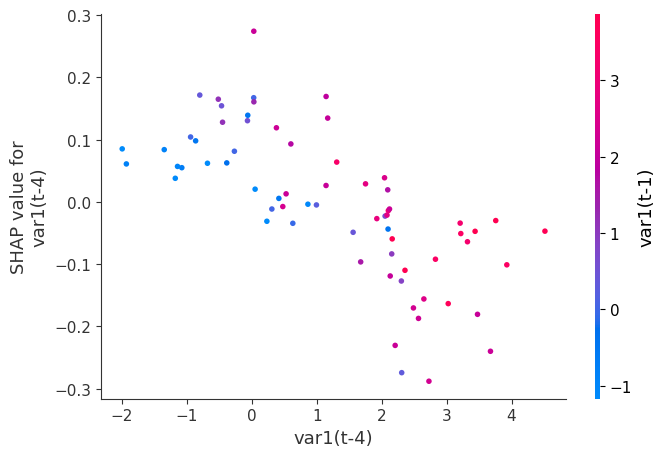

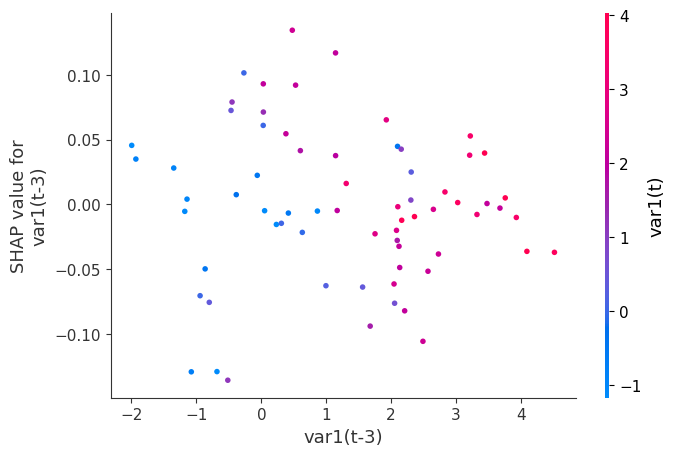

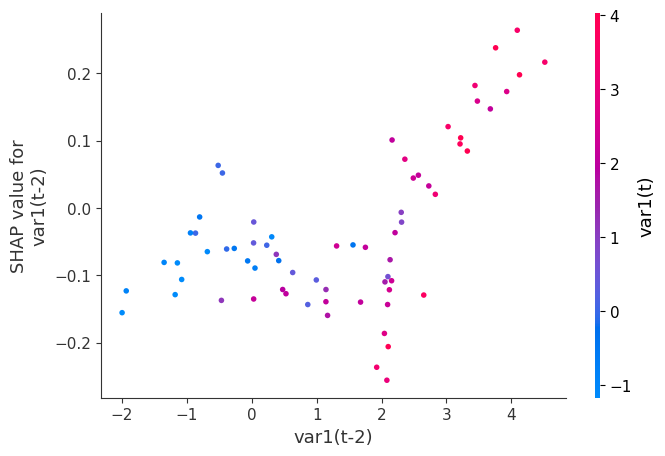

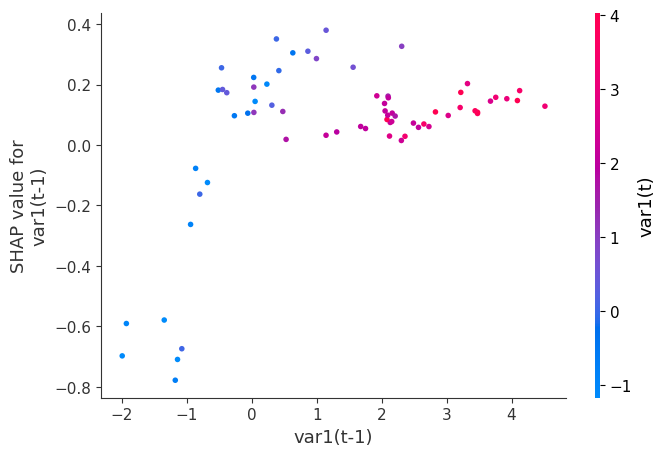

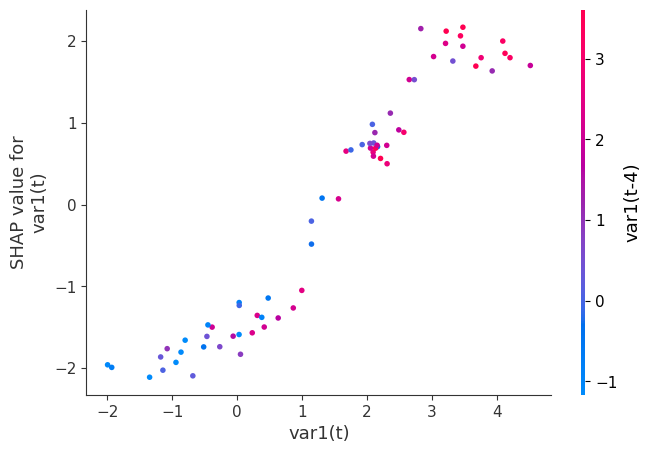

In [48]:
# SHAP Werte berechnen
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trainRFR)

# Abhängigkeits-Plots (Dependence Plots) erstellen
for feature_name in X_trainRFR.columns:
    shap.dependence_plot(feature_name, shap_values, X_trainRFR, feature_names=X_trainRFR.columns)

# Verteilung der SHAP-Werte für ein Beispiel
shap.initjs()
sample_index = 0  # Index des Beispiels, das wir visualisieren möchten
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_trainRFR.iloc[sample_index], feature_names=X_trainRFR.columns)


In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_trainRFR)

shap_values[2]

array([ 0.13445977,  0.09196773, -0.05845276,  0.13770483,  0.88109497])

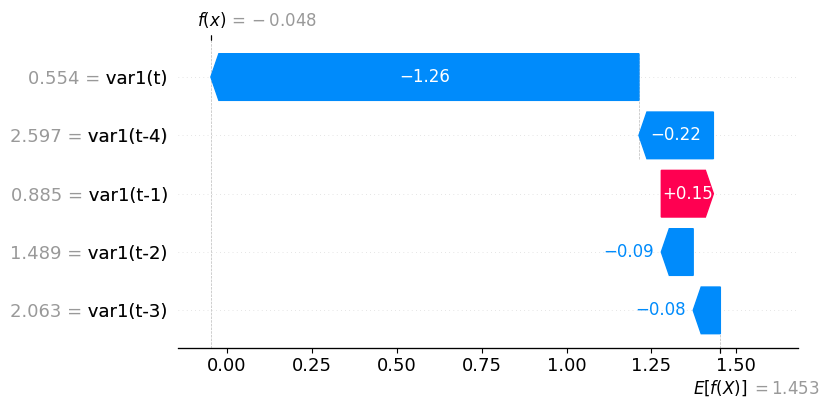

In [50]:
# SHAP Werte berechnen
explainer = shap.Explainer(model, X_trainRFR)
shap_values = explainer(x_testRFR)

# Waterfall Diagramm für eine einzelne Vorhersage (z.B. die erste)
shap.waterfall_plot(shap_values[7])

Feature-Importance und SHAP-Werte
Feature-Importance in Random Forest:

Random Forest ist ein Ensemble-Lernalgorithmus, der mehrere Entscheidungsbäume kombiniert. Jeder Baum trifft Vorhersagen basierend auf verschiedenen Features, und die durchschnittliche Reduktion des Fehlers, wenn ein Feature in den Bäumen verwendet wird, gibt an, wie wichtig dieses Feature ist.
Die Feature-Importance, die von Random Forest zurückgegeben wird, misst den durchschnittlichen Beitrag eines Features zur Vorhersage über alle Bäume hinweg.
SHAP-Werte:

SHAP (SHapley Additive exPlanations) ist eine Methode zur Erklärung der Vorhersagen von Machine-Learning-Modellen. SHAP-Werte messen den Beitrag jedes Features zur Differenz zwischen der Vorhersage und dem durchschnittlichen Modelloutput.
Ein höherer absoluter SHAP-Wert für ein Feature bedeutet, dass das Feature einen größeren Einfluss auf die Vorhersage hat.
Grund für den großen Einfluss von var1(t)
Zeitliche Nähe:

var1(t) repräsentiert den Wert des betrachteten Parameters zur aktuellen Zeit t. Bei zeitlich sequenziellen Daten (wie Zeitreihen) haben die jüngsten Werte oft den größten Einfluss auf zukünftige Werte. Dies liegt daran, dass nahe Werte tendenziell mehr Informationen über den aktuellen Zustand und damit über zukünftige Zustände liefern.
Autokorrelation:

In vielen Zeitreihen gibt es eine hohe Autokorrelation, das heißt, dass die Werte zu einem bestimmten Zeitpunkt stark mit den Werten zu vorherigen Zeitpunkten korrelieren. Dies bedeutet, dass var1(t) in der Regel eine gute Vorhersage für var1(t+1) ist.

FAZIT

Der große Einfluss von var1(t) auf die Vorhersage kann durch die zeitliche Nähe und die Autokorrelation in den Daten erklärt werden. var1(t) enthält die aktuellsten Informationen und ist daher oft der wichtigste Prädiktor für den nächsten Zeitpunkt t+1. Die SHAP-Werte bieten eine detaillierte Erklärung für den Beitrag jedes Features zur Modellvorhersage.

In [51]:
shap_values

.values =
array([[-6.13896749e-02, -4.39236720e-02,  2.96382307e-01,
         2.04280692e-01,  1.95577173e+00],
       [-1.13617668e-01,  1.17240481e-02,  3.13073058e-01,
         1.59109963e-01,  1.48859892e+00],
       [-2.29334379e-01,  9.30839068e-03,  1.90699044e-01,
         9.52302200e-02,  5.94877017e-01],
       [-2.34039476e-01, -8.06034344e-04,  9.57876808e-02,
         7.17780310e-02,  8.83897081e-01],
       [-2.66429483e-01, -1.20236757e-02,  3.18228231e-02,
         7.97692822e-02,  5.82742361e-01],
       [-2.67190500e-01, -5.12208634e-02,  7.48570850e-02,
         1.36621645e-01,  4.44458883e-02],
       [-1.15257912e-01,  2.10723805e-02, -9.11540728e-02,
         1.62411974e-01, -1.10503511e+00],
       [-2.19286732e-01, -8.00092501e-02, -9.39265740e-02,
         1.53372482e-01, -1.26098167e+00],
       [ 2.12584692e-02, -1.28904559e-02, -8.79509730e-02,
         7.71207341e-02,  2.55485079e-02],
       [-5.03585984e-02, -4.77169406e-02, -9.64185476e-02,
         1.46

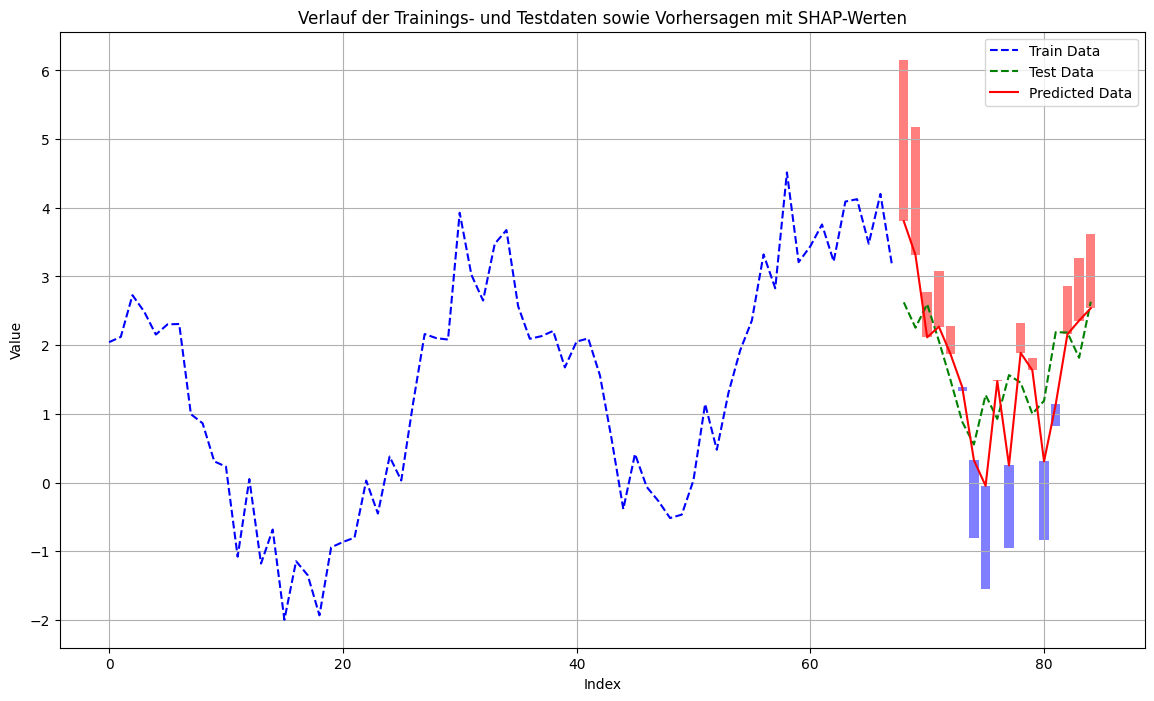

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Plotten der tatsächlichen und vorhergesagten Zeitreihe
plt.figure(figsize=(14, 8))

# Trainingsdaten plotten
plt.plot(np.arange(len(y_trainRFR)), y_trainRFR, label='Train Data', color='blue', linestyle='--')

# Testdaten plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_testRFR, label='Test Data', color='green', linestyle='--')

# Vorhergesagte Werte plotten
plt.plot(np.arange(len(y_trainRFR), len(y_trainRFR) + len(y_testRFR)), y_pred, label='Predicted Data', color='red')

# SHAP-Werte als Balken hinzufügen
for i in range(len(y_pred)):  # Sicherstellen, dass wir nur über die Länge von y_pred iterieren
    shap_sum = shap_values[i].values.sum()  # Summe der SHAP-Werte für eine Vorhersage, .values um den numerischen Wert zu bekommen
    plt.bar(i + len(y_trainRFR), shap_sum, bottom=y_pred[i], color="red" if shap_sum > 0 else "blue", alpha=0.5)

plt.xlabel('Index')
plt.grid()
plt.ylabel('Value')
plt.title('Verlauf der Trainings- und Testdaten sowie Vorhersagen mit SHAP-Werten')
plt.legend()
plt.show()




In [53]:
y_pred

array([ 3.804314,  3.312081,  2.113973,  2.26981 ,  1.869074,  1.390706,
        0.32523 , -0.047639,  1.476279,  0.24903 ,  1.888569,  1.633814,
        0.307975,  1.139648,  2.157963,  2.357583,  2.537507])

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte (ersetzen Sie diese durch Ihre tatsächlichen SHAP-Werte und Basisvorhersage)
base_value = np.mean(y_pred) # Basisvorhersage (z.B. Mittelwert der Zielvariable)

# Kumulative Summe der Basisvorhersage und SHAP-Werte berechnen
cumulative_contributions = np.cumsum([base_value] + shap_values)

# Wasserfall-Plot erstellen
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i in range(1, len(cumulative_contributions)):
    plt.bar(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
            bottom=cumulative_contributions[i-1], 
            color='red' if shap_values[i-1] > 0 else 'blue', 
            alpha=0.7)

# Linie zeichnen
plt.step(range(len(cumulative_contributions)), cumulative_contributions, where='mid', color='k', linestyle='--')

# Beschriftungen hinzufügen
plt.xticks(range(len(cumulative_contributions)), ['Base'] + feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axhline(base_value + sum(shap_values), color='r', linestyle='-', label=f'Prediction: {base_value + sum(shap_values):.2f}')
plt.legend()
plt.show()


TypeError: '>' not supported between instances of 'Explanation' and 'int'

<Figure size 1000x600 with 0 Axes>

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte (ersetzen Sie diese durch Ihre tatsächlichen SHAP-Werte und Basisvorhersage)
# Base value berechnen
base_value = np.mean(y_pred)  # Basisvorhersage (z.B. Mittelwert der Zielvariable)

# Annahme: shap_values ist ein 2D-Array oder eine Liste von Arrays (shape: [n_samples, n_features])
# Hier extrahieren wir die SHAP-Werte für das erste Beispiel
shap_values_example = shap_values[0]

# Kumulative Summe der Basisvorhersage und SHAP-Werte berechnen
cumulative_contributions = np.cumsum([base_value] + list(shap_values_example))

# Wasserfall-Plot erstellen
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i in range(1, len(cumulative_contributions)):
    plt.bar(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
            bottom=cumulative_contributions[i-1], 
            color='red' if shap_values_example[i-1] > 0 else 'blue', 
            alpha=0.7)

# Linie zeichnen
plt.step(range(len(cumulative_contributions)), cumulative_contributions, where='mid', color='k', linestyle='--')

# Beschriftungen hinzufügen
plt.xticks(range(len(cumulative_contributions)), ['Base'] + feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axhline(base_value + sum(shap_values_example), color='r', linestyle='-', label=f'Prediction: {base_value + sum(shap_values_example):.2f}')
plt.legend()
plt.show()


TypeError: '>' not supported between instances of 'Explanation' and 'int'

<Figure size 1000x600 with 0 Axes>

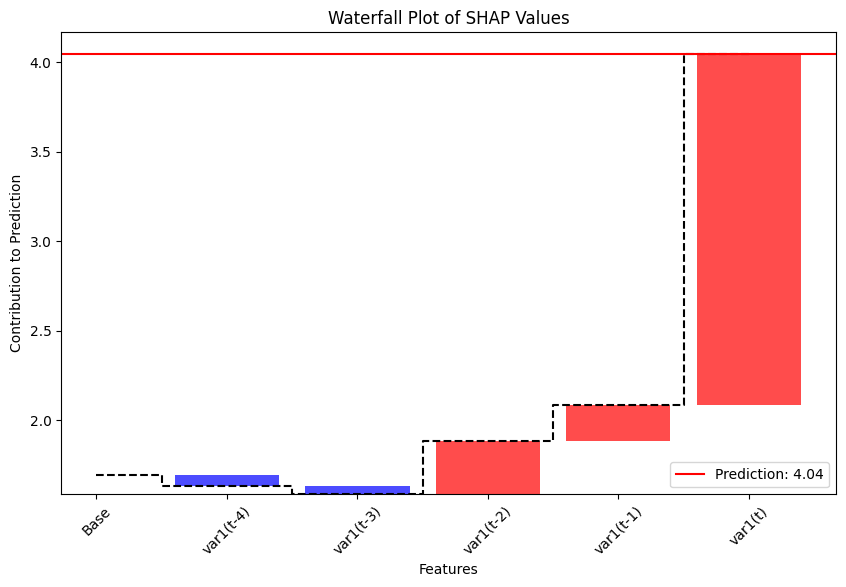

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte (ersetzen Sie diese durch Ihre tatsächlichen SHAP-Werte und Basisvorhersage)
base_value = np.mean(y_pred)  # Basisvorhersage (z.B. Mittelwert der Zielvariable)

# Annahme: shap_values ist eine Liste von shap.Explanation-Objekten
# Hier extrahieren wir die SHAP-Werte für das erste Beispiel
shap_values_example = shap_values[0].values

# Kumulative Summe der Basisvorhersage und SHAP-Werte berechnen
cumulative_contributions = np.cumsum([base_value] + list(shap_values_example))

# Wasserfall-Plot erstellen
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i in range(1, len(cumulative_contributions)):
    plt.bar(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
            bottom=cumulative_contributions[i-1], 
            color='red' if shap_values_example[i-1] > 0 else 'blue', 
            alpha=0.7)

# Linie zeichnen
plt.step(range(len(cumulative_contributions)), cumulative_contributions, where='mid', color='k', linestyle='--')

# Beschriftungen hinzufügen
plt.xticks(range(len(cumulative_contributions)), ['Base'] + feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axhline(base_value + sum(shap_values_example), color='r', linestyle='-', label=f'Prediction: {base_value + sum(shap_values_example):.2f}')
plt.legend()
plt.show()


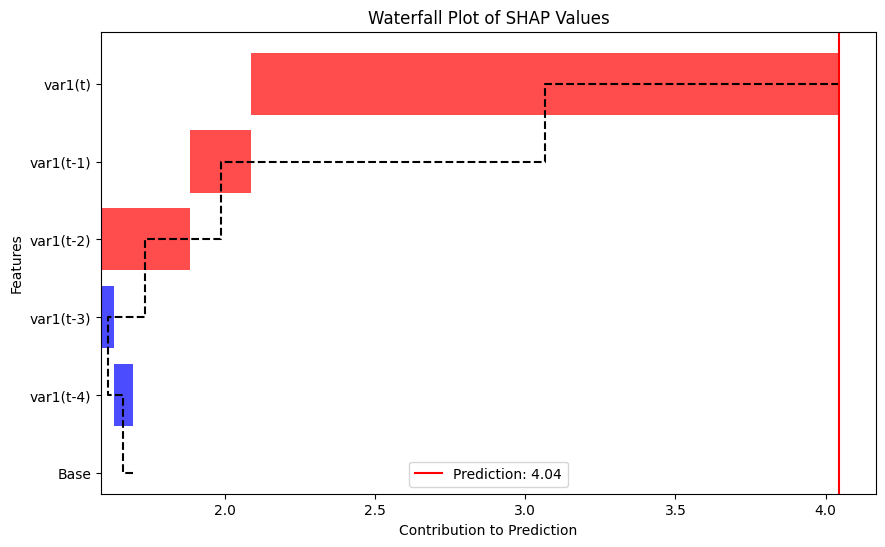

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Beispielwerte (ersetzen Sie diese durch Ihre tatsächlichen SHAP-Werte und Basisvorhersage)
base_value = np.mean(y_pred)  # Basisvorhersage (z.B. Mittelwert der Zielvariable)

# Annahme: shap_values ist eine Liste von shap.Explanation-Objekten
# Hier extrahieren wir die SHAP-Werte für das erste Beispiel
shap_values_example = shap_values[0].values
feature_names = shap_values[0].feature_names  # Annahme: Feature-Namen sind in den SHAP-Werten enthalten

# Kumulative Summe der Basisvorhersage und SHAP-Werte berechnen
cumulative_contributions = np.cumsum([base_value] + list(shap_values_example))

# Wasserfall-Plot erstellen
plt.figure(figsize=(10, 6))

# Balken zeichnen
for i in range(1, len(cumulative_contributions)):
    plt.barh(i, cumulative_contributions[i] - cumulative_contributions[i-1], 
             left=cumulative_contributions[i-1], 
             color='red' if shap_values_example[i-1] > 0 else 'blue', 
             alpha=0.7)

# Linie zeichnen
plt.step(cumulative_contributions, range(len(cumulative_contributions)), where='mid', color='k', linestyle='--')

# Beschriftungen hinzufügen
plt.yticks(range(len(cumulative_contributions)), ['Base'] + feature_names)
plt.ylabel('Features')
plt.xlabel('Contribution to Prediction')
plt.title('Waterfall Plot of SHAP Values')
plt.axvline(base_value + sum(shap_values_example), color='r', linestyle='-', label=f'Prediction: {base_value + sum(shap_values_example):.2f}')
plt.legend()
plt.show()
